In [1]:
from __future__ import division

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import matplotlib as mpl
from wyrm import processing as proc
from wyrm.types import Data
from wyrm import plot
from wyrm.io import load_bcicomp3_ds1

import scipy.signal as signal
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Mat

In [2]:
DATA_DIR = 'data/mat/'
TRUE_LABELS = 'data/raw/test/test_label.txt'

In [3]:
dat_train, dat_test = load_bcicomp3_ds1(DATA_DIR)

true_labels = np.loadtxt(TRUE_LABELS).astype('int')
true_labels[true_labels == -1] = 0

In [4]:
dat_train.axes[0]

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [5]:
def plot_csp_pattern(a):
    # get symmetric min/max values for the color bar from first and last column of the pattern
    maxv = np.max(np.abs(a[:, [0, -1]]))
    minv = -maxv
    
    im_args = {'interpolation' : 'None', 
           'vmin' : minv, 
           'vmax' : maxv
           }

    # plot
    ax1 = plt.subplot2grid((1,11), (0,0), colspan=5)
    ax2 = plt.subplot2grid((1,11), (0,5), colspan=5)
    ax3 = plt.subplot2grid((1,11), (0,10))

    ax1.imshow(a[:, 0].reshape(8, 8), **im_args)
    ax1.set_title('Pinky')

    ax = ax2.imshow(a[:, -1].reshape(8, 8), **im_args)
    ax2.set_title('Tongue')

    plt.colorbar(ax, cax=ax3)
    plt.tight_layout()


def preprocess(data, filt=None):
    dat = data.copy()
    fs_n = dat.fs / 2
    
    b, a = proc.signal.butter(5, [13 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
    
    b, a = proc.signal.butter(5, [9 / fs_n], btype='high')
    dat = proc.filtfilt(dat, b, a)
    
    dat = proc.subsample(dat, 50)

    if filt is None:
        filt, pattern, _ = proc.calculate_csp(dat)
        plot_csp_pattern(pattern)
    dat = proc.apply_csp(dat, filt)
    
    dat = proc.variance(dat)
    dat = proc.logarithm(dat)
    return dat, filt

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/zhuoxuanju/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/zhuoxuanju/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/zh

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Nadeem.ttc', name='Nadeem', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpDBol.otf', name='STIXIntegralsUpD', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXNonUniBolIta.otf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Keyboard.ttf', name='.Keyboard', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSans

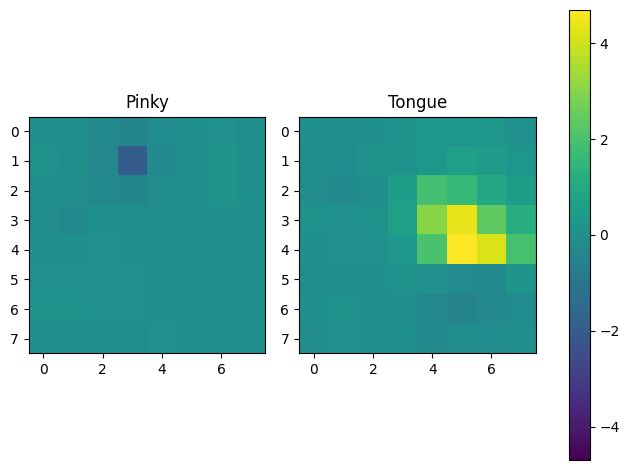

In [6]:
fv_train, filt = preprocess(dat_train)
fv_test, _ = preprocess(dat_test, filt)

In [7]:
fv_train.data.shape

(278, 2)

In [8]:
cfy = proc.lda_train(fv_train)
result = proc.lda_apply(fv_test, cfy)
result = (np.sign(result) + 1) / 2
print('LDA Accuracy %.2f%%' % ((result == true_labels).sum() / len(result)))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
LDA Accuracy 0.94%


## CSSD

In [9]:
X_train = dat_train.data
X_test = dat_test
y_train = dat_train.axes[0]

In [10]:
n_trials_train = 278    
n_trials_test = 100   
n_channels = 64        
n_samples = 3000        
fs = 1000             


# ----------------------------
# Feature Extraction Functions
# ----------------------------
def extract_bandpower(channel_data, fs, band=(8, 30)):
    """
    Compute bandpower using Welch's method for a given channel.
    """
    f, Pxx = signal.welch(channel_data, fs=fs, nperseg=fs)
    idx_band = np.logical_and(f >= band[0], f <= band[1])
    band_power = np.trapz(Pxx[idx_band], f[idx_band])
    return band_power

def extract_mean_waveform(channel_data):
    """
    Compute the mean amplitude of a channel (mean waveform feature).
    """
    return np.mean(channel_data)

# ----------------------------
# Simplified CSSD (Spatial Filtering)
# ----------------------------
def cssd(trials, labels):
    """
    A simplified placeholder for Common Spatial Subspace Decomposition (CSSD).
    Computes spatial filters based on the class-wise average covariance matrices.
    """
    n_trials, n_channels, _ = trials.shape
    # Compute covariance matrix for each trial
    cov_matrices = np.array([np.cov(trial) for trial in trials])
    
    # Average covariance per class
    cov_class0 = np.mean(cov_matrices[labels==0], axis=0)
    cov_class1 = np.mean(cov_matrices[labels==1], axis=0)
    
    # Composite covariance and whitening transform
    cov_total = cov_class0 + cov_class1
    eigvals, eigvecs = np.linalg.eigh(cov_total)
    inv_sqrt = eigvecs @ np.diag(1.0 / np.sqrt(eigvals + 1e-10)) @ eigvecs.T
    
    # Whiten the class covariance matrices
    S0 = inv_sqrt @ cov_class0 @ inv_sqrt.T
    S1 = inv_sqrt @ cov_class1 @ inv_sqrt.T
    
    # Solve a generalized eigenvalue problem (here, we use a simplified approach)
    eigvals_cssd, eigvecs_cssd = np.linalg.eigh(S0, S0 + S1)
    # Sort eigenvectors by eigenvalue in descending order
    order = np.argsort(eigvals_cssd)[::-1]
    W = eigvecs_cssd[:, order]
    return W

def apply_cssd(trial, W, n_components=4):
    """
    Project a trial using the first n_components spatial filters.
    """
    # trial shape: (n_channels, n_samples)
    W_reduced = W[:, :n_components]
    return W_reduced.T @ trial  # Resulting shape: (n_components, n_samples)

def extract_features(trials, fs, W, n_components=4):
    """
    For each trial, first apply CSSD, then extract bandpower and mean waveform features
    from each spatially filtered channel.
    """
    feature_list = []
    for trial in trials:
        # Apply spatial filtering (CSSD)
        trial_proj = apply_cssd(trial, W, n_components=n_components)
        bandpower_feats = []
        mean_waveform_feats = []
        for proj in trial_proj:
            bp = extract_bandpower(proj, fs, band=(8,30))
            mw = extract_mean_waveform(proj)
            bandpower_feats.append(bp)
            mean_waveform_feats.append(mw)
        # Concatenate features from all components
        features_trial = np.concatenate([bandpower_feats, mean_waveform_feats])
        feature_list.append(features_trial)
    return np.array(feature_list)


In [11]:
W = cssd(X_train, y_train)

# Extract features from training and test data
features_train = extract_features(X_train, fs, W, n_components=4)
features_test = extract_features(X_test, fs, W, n_components=4)

# ----------------------------
# Feature Selection using Fisher Discriminant (ANOVA F-test)
# ----------------------------
selector = SelectKBest(score_func=f_classif, k='all')
features_train_selected = selector.fit_transform(features_train, y_train)
features_test_selected = selector.transform(features_test)

# ----------------------------
# Classification with a Linear SVM
# ----------------------------
clf = SVC(kernel='linear')
clf.fit(features_train_selected, y_train)

# Predict on test data
y_pred = clf.predict(features_test_selected)
print("Predicted test labels:", y_pred)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


: 